# Анализ сервиса аренды самокатов GoFast

**Описание проекта** 

От популярного сервиса аренды самокатов GoFast были переданы данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

*без подписки*
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

*с подпиской Ultra*
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.


**Цель исследования** 

Проверить некоторые гипотезы на основе анализа данных.

**Ход исследования** 

Для начала будет произведена загрузка и обзор данных: на этом этапе лишь узнаем общую информацию о данных. Затем будет произведена предобработка данных: поиск явных и неявных дубликатов, выявление пропусков и их замена, если такие будут обнаржуены, приведение данных к правильному типу данных и т.д. Следом проведем исследовательский анализ данных: опишем и визуализируем основную информацию, выявим, какие действия с данными нужны для дальнейшей проверки гипотез, и выполним их. Затем проверим гипотезы и сделаем выводы.

***План работы***


[***Шаг 1. Загрузка данных***](#1)

[***Шаг 2. Предобработка данных***](#2)

[***Шаг 3. Исследовательский анализ данных***](#3)

[***Шаг 4. Объединение данных***](#4)

[***Шаг 5. Подсчет выручки***](#5)

[***Шаг 6. Проверка гипотез***](#6)

[***Шаг 7. Распределения***](#7)

[***Шаг 8. Общий вывод***](#8)

<a id ='1'></a>
### Шаг 1. Загрузка данных

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# считаем CSV-файлы и сохраним их в датафреймы
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# создадим универсальную функцию, которая выводит необходимые характеристики для датафрейма
def data_info(df):
    print(df.head())
    df.info()
    print(df.duplicated().sum())

In [4]:
data_info(users)

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
31


В датафрейме 1565 строк, при этом все столбцы полностью заполнены (нет NaN), присутствует 31 строка дубликатов: во время предобработки данных дубликаты надо будет убрать.

In [5]:
data_info(rides)

   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
0


В датафрейме 18068 строк, при этом все столбцы полностью заполнены (нет NaN), дубликаты отсутствуют.

In [6]:
data_info(subscriptions)

  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
0


В датафрейме две строки, все столбцы полностью заполнены (нет NaN), строки друг друга не дублируют.

<a id ='2'></a>
### Шаг 2. Предобработка данных

**Обработка дубликатов**

Явные дубликаты присутствуют только в датафрейме `users`. Очистим этот датафрейм от дубликатов.

In [7]:
users = users.drop_duplicates()
users.duplicated().sum()

0

In [8]:
# проверим users на наличие неявных дубликатов
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Изменение типа данных**

Столбец `date` датафрейма `rides` содержит информацию о дате, однако имеет тип данных `object`. Приведем данный столбец к нужному типу данных.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**Добавление нового столбца**

Создадим новый столбец с информацией о номере месяца в датафрейме `rides` на основе столбца `date`.

Для этого сначала проверим, за какой период имеются данные.

In [10]:
min(rides['date']), max(rides['date'])

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-30 00:00:00'))

Данные с информацией о дате представлены только за 2021 год. Теперь смело можем создавать новый столбец с информацией о номере месяца.

In [11]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides['month'].head()

0    1
1    1
2    4
3    8
4    8
Name: month, dtype: int64

<a id ='3'></a>
### Шаг 3. Исследовательский анализ данных

Опишим и визуализируем общую информацию о пользователях и поездках.

*1. Частота встречаемости городов*

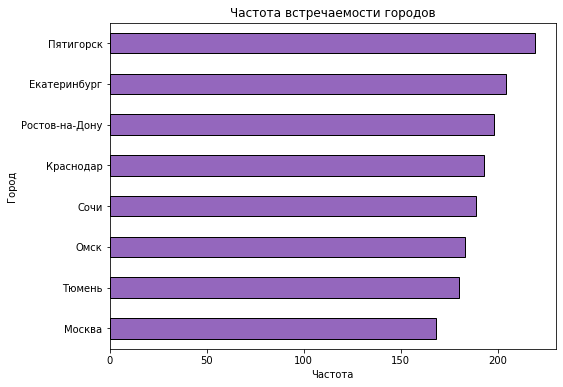

In [12]:
# подсчитываем частоту для уникальных значений столбца city, сортируем по частоте и строим график
users['city'].value_counts().sort_values().plot(
    kind='barh',
    figsize=(8,6),
    ec='black',
    title='Частота встречаемости городов',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Частота');
plt.ylabel('Город');

In [13]:
users['city'].value_counts().sort_values(ascending=False)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

По графику заметно, что чаще всего в данных встречаются пользователи из городов Пятигорск и Екатеринбург, при этом меньше всего пользователей из города Москвы.

*2. Соотношение пользователей с подпиской и без подписки*

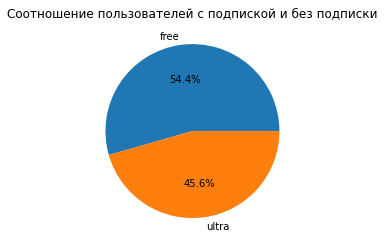

In [14]:
# cтроим круговую диаграмму для информации о подписках
plt.pie(users['subscription_type'].value_counts(),
        labels=['free', 'ultra'], autopct='%1.1f%%');
# подписываем график
plt.title('Соотношение пользователей с подпиской и без подписки');

По графику заметно, что пользователей без подписки больше, чем пользователей с подпиской, что вполне логично, ведь не так часто люди пользуются самокатами каждый день, чтобы приобретать подписку. Однако стоит отметить, что число пользователй с подпиской не намного меньше числа пользователей без подписки. Можно предположить, что подписка довольно популярна в сервисе.

*3. Возраст пользователей*

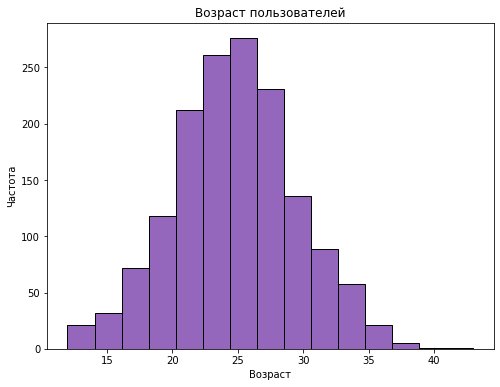

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [15]:
# строим график для столбца с данными о возрасте
users['age'].plot(
    kind='hist',
    bins=15,
    figsize=(8,6),
    ec='black',
    title='Возраст пользователей',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Возраст');
plt.ylabel('Частота');
plt.show()
# выводим описание данных
users['age'].describe()

По графику заметно, что пользователи по возрасту распределены нормально. Средний возраст пользователей сервиса находится в промежутке 23-26 лет, при этом встречаются и пользователи с возрастом меньше 15 лет и больше 40 лет, однако таких пользователей очень мало.

Основная масса пользователей находится в промежутке от 22 до 28 лет.

*4. Расстояние, которое пользователь преодолел за одну поездку*

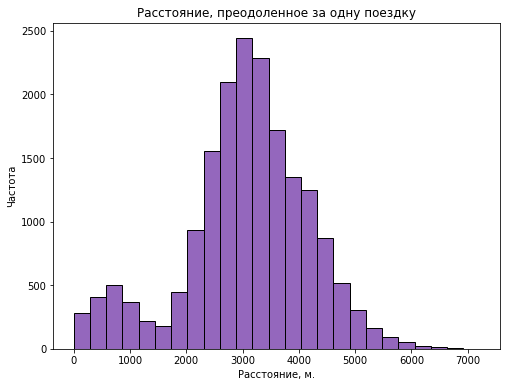

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [16]:
rides['distance'].plot(
    kind='hist',
    bins=25,
    figsize=(8,6),
    ec='black',
    title='Расстояние, преодоленное за одну поездку',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Расстояние, м.');
plt.ylabel('Частота');
plt.show()
# выводим описание данных
rides['distance'].describe()

По графику заметно, что чаще всего пользователи проезжают около 3000 метров, при этом есть длинные поездки (более 6000 метров), и короткие (менее 1000 метров). И хоть и наблюдается некое повышение частотности коротких поездок, они, как и длинные поездки, все равно остаются немногочисленными. 

Основная масса пользователей преодолевает расстояние от 2544 до 3777 метров за одну поездку.

*5. Продолжительность поездок*

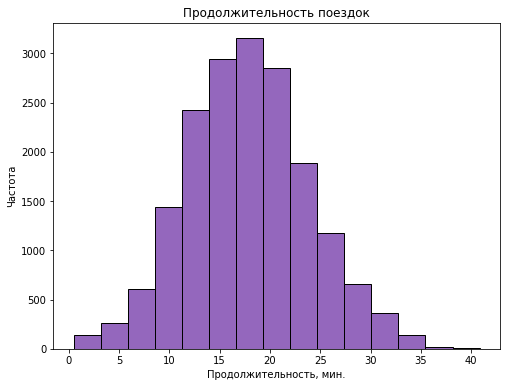

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [17]:
rides['duration'].plot(
    kind='hist',
    bins=15,
    figsize=(8,6),
    ec='black',
    title='Продолжительность поездок',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Продолжительность, мин.');
plt.ylabel('Частота');
plt.show()
# выводим описание данных
rides['duration'].describe()

Чаще всего продолжительность поездки составляет около 18 минут, при этом есть как и короткие поездки (менее 5 мин.), так и долгие поездки (более 35 мин.), однако их число в общем количестве поездок слишком мало.

Основная масса поездок лежит в промежутке 14-22 минут.

**Вывод**

Были произведены визуализация и описание общей информации о пользователях и поездках. Аномалии во время исследовательского анализа данных посредством визуализации данных выявлены не были.

Можно составить портрет типичного пользователя сервиса аренды самокатов GoFast: человек 25 лет из Пятигорска с бесплатной подпиской на сервис, который преодолевает около 3 км. за поездку, продолжительностью 18 минут.

<a id ='4'></a>
### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [18]:
# присоединяем к датафрейму rides датафрейм users
data = rides.merge(users, on='user_id')
# присоединяем к датафрейму data датафрейм subscriptions
data = data.merge(subscriptions, on='subscription_type')
data_info(data)
len(rides)

   user_id     distance   duration       date  month  name  age    city  \
0        1  4409.919140  25.599769 2021-01-01      1  Кира   22  Тюмень   
1        1  2617.592153  15.816871 2021-01-18      1  Кира   22  Тюмень   
2        1   754.159807   6.232113 2021-04-20      4  Кира   22  Тюмень   
3        1  2694.783254  18.511000 2021-08-11      8  Кира   22  Тюмень   
4        1  4028.687306  26.265803 2021-08-28      8  Кира   22  Тюмень   

  subscription_type  minute_price  start_ride_price  subscription_fee  
0             ultra             6                 0               199  
1             ultra             6                 0               199  
2             ultra             6                 0               199  
3             ultra             6                 0               199  
4             ultra             6                 0               199  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Col

18068

Объединение датафреймов произошло корректно: пропуски отсутствуют, данные не были потеряные, лишние записи не появились, так как количество строк полученного датафрейма совпадает с количеством строк исходной таблицы `rides`.

Теперь поместим данные о пользователях с подпиской и без в разные датафреймы.

In [19]:
# дф с данными о поездках пользователей без подписки
data_free = data.loc[data['subscription_type'] == 'free']
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [20]:
# дф с данными о поездках пользователей с подпиской
data_ultra = data.loc[data['subscription_type'] == 'ultra']
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [21]:
# проверим, совпадает ли совокупный размер датафреймов с кол-вом строк в исходной табл.
len(data_free) + len(data_ultra), len(data)

(18068, 18068)

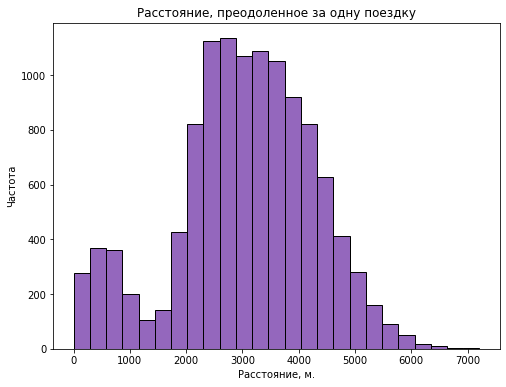

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [22]:
data_free['distance'].plot(
    kind='hist',
    bins=25,
    figsize=(8,6),
    ec='black',
    title='Расстояние, преодоленное за одну поездку',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Расстояние, м.');
plt.ylabel('Частота');
plt.show()
#выводим описание данных
data_free['distance'].describe()

Можем заметить, что чаще всего пользователи без подписки преодолевают расстояние в 2500-2600 метров за одну поездку. Также имеется небольшое повышение частоты на расстоянии в 500-600 метров за поездку. Это не сильно отличается от распределения данных для всех пользователей (с подпиской и без).

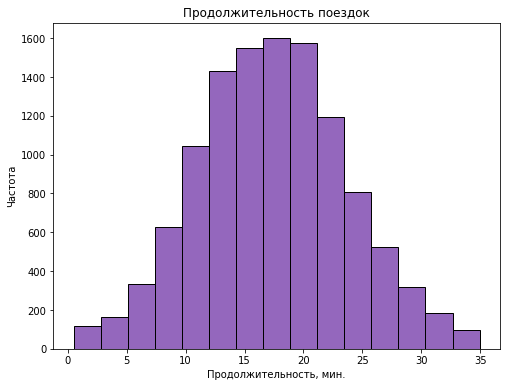

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [23]:
data_free['duration'].plot(
    kind='hist',
    bins=15,
    figsize=(8,6),
    ec='black',
    title='Продолжительность поездок',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Продолжительность, мин.');
plt.ylabel('Частота');
plt.show()
#выводим описание данных
data_free['duration'].describe()

Продолжительность поездки у пользователей без подписки чаще всего 17-18 минут, что так же не отличается от распределения данных для всех пользователей (с подпиской и без). Разброс здесь небольшой, наблюдаются значения длительности поездок в 30-35 минут, но они немногочислены.

*2. Пользователи с подпиской*

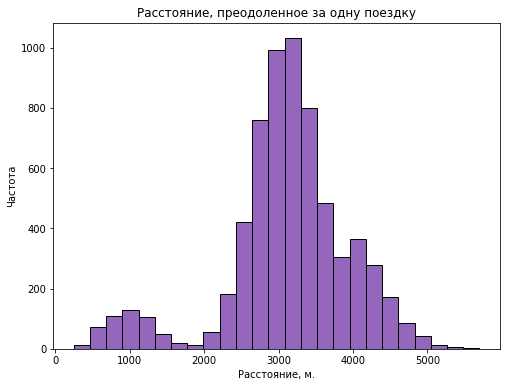

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [24]:
data_ultra['distance'].plot(
    kind='hist',
    bins=25,
    figsize=(8,6),
    ec='black',
    title='Расстояние, преодоленное за одну поездку',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Расстояние, м.');
plt.ylabel('Частота');
plt.show()
#выводим описание данных
data_ultra['distance'].describe()

Чаще всего пользователи с подпиской преодолевают расстояние в 3000-3200 метров за одну поездку. Здесь можно отметить, что по сравнению с диаграммой преодоленного расстояния за поездку для пользователей без подписки наблюдается небольшое смещение графика вправо. Иными словами, *пользователи с подпиской обычно преодолевают большее расстояние за поездку, нежели пользователи без подписки.*

Также стоит отметить, что повышение частоты на расстоянии в 1000 метров намного меньше (и смещено вправо), чем на графике пользователей без подписки, что еще раз подтверждает то, что пользователи с подпиской преодолевают за поездку большее расстояние.

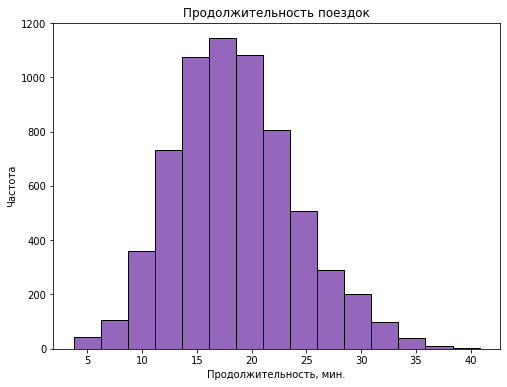

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [25]:
data_ultra['duration'].plot(
    kind='hist',
    bins=15,
    figsize=(8,6),
    ec='black',
    title='Продолжительность поездок',
    color='#9467bd'
);
# задаем подписи для осей графика
plt.xlabel('Продолжительность, мин.');
plt.ylabel('Частота');
plt.show()
#выводим описание данных
data_ultra['duration'].describe()

Чаще всего продолжительность поездки пользователей с подпиской составляет 18 минут, что не отличается от результата пользователей без подписки. Однако стоит отметить, что разброс значений в данном случае больше: самые продолжительные поездки хоть и немногочислены, но могут быть больше 40 минут.

**Вывод**

Пользователи без подписки и с подпиской имеют различия. Так, пользователи с подпиской обычно преодолевают большее расстояние за поездку, нежели пользователи без подписки. Средняя продолжительность поездки у двух категорий одинакова, однако ее разброс разный. Так, пользователи с подпиской могут совершать более продолжительные поездки, чем пользователи без подписки. Пользователи с подпиской, вероятно, более знакомы с сервисом, имеют предпочтительные маршруты, что может приводить к более стабильным и продолжительным поездкам. Пользователи без подписки, возможно, чаще используют сервис для краткосрочных и случайных поездок, что и влияет на разброс длительности.

<a id ='5'></a>
### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [26]:
# округлим продолжительность каждой поездки в большую сторону
data['duration'] = np.ceil(data['duration'])
# создание агрегированного датафрейма
rev = pd.DataFrame(data.groupby(['user_id', 'month']).agg(
        {'distance':'sum',
         'duration':'sum',
         'age':'count',
         'minute_price' :'first',
         'start_ride_price':'first',
         'subscription_fee':'first'}))
# переименовывание столбцa
rev = rev.rename(columns={'age':'quanity'})

rev.head()

distance  duration  quanity  minute_price  start_ride_price  \
user_id month                                                                   
1       1      7027.511294      42.0        2             6                 0   
        4       754.159807       7.0        1             6                 0   
        8      6723.470560      46.0        2             6                 0   
        10     5809.911100      32.0        2             6                 0   
        11     7003.499363      56.0        3             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

Вычислим помесячную выручку, которую принес каждый пользователь и запишем ее в столбец `revenue`.

In [27]:
# подсчет ежемесячной выручки от каждого пользователя
rev['revenue'] = (
    # стартовая цена поездки * количество поездок +
    (rev['start_ride_price'] * rev['quanity']) + 
    # продолжительность поездки * цена за минуту поездки +
    (rev['duration'] * rev['minute_price']) + 
    # цена ежемесячной подписки
    rev['subscription_fee']
)

rev.head()

distance  duration  quanity  minute_price  start_ride_price  \
user_id month                                                                   
1       1      7027.511294      42.0        2             6                 0   
        4       754.159807       7.0        1             6                 0   
        8      6723.470560      46.0        2             6                 0   
        10     5809.911100      32.0        2             6                 0   
        11     7003.499363      56.0        3             6                 0   

               subscription_fee  revenue  
user_id month                             
1       1                   199    451.0  
        4                   199    241.0  
        8                   199    475.0  
        10                  199    391.0  
        11                  199    535.0

In [28]:
rev['revenue'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: revenue, dtype: float64

**Вывод**

Вычислив ежемесячную выручку каждого пользователя, можно сделать вывод, что в среднем каждый пользователь ежемесечно приносит около 340 рублей сервису. При этом наблюдаются как низкие значения, такие как 58 рублей в месяц, так и высокие значения, такие как 1428 рублей в месяц.

<a id ='6'></a>
### Шаг 6. Проверка гипотез

*6.1 Первая гипотеза*

Необходимо выяснить, тратят ли пользователи с подпиской больше времени на поездки. Для проверки этой гипотезы мы воспользуемся первоначальными данными о продолжительности каждой поездки, разделяя их для подписчиков и пользователей без подписки.

***H₀: Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.***

***H₁: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.***


Для начала проверим, одинакового ли размера выборки для принятия решения о том, различаются ли их дисперссии.

In [29]:
len(data_free), len(data_ultra)

(11568, 6500)

Выборки действительно разного размера, соответственно параметр `equal_var` следует поменять.

In [30]:
# задаем уровень стат. значимости
alpha = 0.05
# проводим t-тест для двух ген. совокупностей
result = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False, alternative='greater')
# выводим p-value
print('p-value:', result.pvalue)
# проверям p-value и принимаем решение
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нельзя отвергнуть нулевую гипотезу.')

p-value: 5.6757813771289775e-37
Нулевая гипотеза отвергается.


Нулевая гипотеза отвергнута, есть основания утверждать, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Это может значить, что для компании пользователи с подпиской более выгодны. Следует уделить особое внимание пользователям с подпиской и исследовать методы более эффективного привлечения пользователей к оформлению подписки.

*6.2 Вторая гипотеза*

Имеются данные о том, что расстояние одной поездки в *3130 метров* — оптимальное с точки зрения износа самоката. Стоит проверить, не превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, 3130 метров.


***H₀: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м.***

***H₁: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130м.***


In [31]:
# проводим t-тест для равенства среднего ген. совокупности числу
result = st.ttest_1samp(data_ultra['distance'], 3130, alternative='greater')
# выводим p-value
print('p-value:', result.pvalue)
# проверям p-value и принимаем решение
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нельзя отвергнуть нулевую гипотезу.')

p-value: 0.9195368847849785
Нельзя отвергнуть нулевую гипотезу.


Нулевую гипотезу отвергнуть нельзя, то есть мы не имеем статистически значимых доказательств в пользу того, что среднее расстояние, пройденное пользователями с подпиской за одну поездку, превышает 3130 метров. Если посмотреть на величину p-value, то можно предположить, что расстояние, пройденное пользователями с подпиской за одну поездку, даже меньше 3130м, то есть является оптимальным с точки зрения износа самоката.

*6.3 Третья гипотеза*

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки и сделаем вывод.


***H₀: Помесячная выручка от пользователей с подпиской по месяцам  равна помесячной выручки от пользователей без подписки***

***H₁: Помесячная выручка от пользователей с подпиской по месяцам  больше помесячной выручки от пользователей без подписки***

Выше мы уже уедились в том, что пользователей с подпиской и без разное количество, соответственно в статтесте нужно будет поменять параметр `equal_var`.

In [32]:
# проводим t-тест для двух ген. совокупностей
result = st.ttest_ind(
    rev[rev['subscription_fee'] == 199]['revenue'],
    rev[rev['subscription_fee'] == 0]['revenue'],
    equal_var=False, alternative='greater')
# выводим p-value
print('p-value:', result.pvalue)
# проверям p-value и принимаем решение
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нельзя отвергнуть нулевую гипотезу.')

p-value: 8.874140893976874e-40
Нулевая гипотеза отвергается.


Нулевая гипотеза отвергнута, есть основания утверждать, что помесячная выручка от пользователей с подпиской по месяцам больше помесячной выручки от пользователей без подписки. Это может быть связано с тем, что пользователи с подпиской чаще и активнее используют услуги компании. В связи с этим можно порекомендовать активно продвигать и стимулировать подписку среди клиентов, предоставляя им дополнительные преимущества, скидки или специальные предложения. Также стоит рассмотерть возможность разработки и усовершенствования программы лояльности для подписчиков

*6.4 Ситуация*

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

В таком случае для проверки гипотезы технической команды о снижении количества обращений в техподдержку стоило бы применить *t-тест для зависимых(парных) выборок.* Альтернативная гипотеза была бы левосторонняя. Для этого требовалось бы применение метода `scipy.stats.ttest_rel()`. При этом размеры выборок должны быть одинаковы и подразумевается, что порядок данных для каждого пользователя о количестве обращений до обновления и после него тоже одинаковый.

<a id ='7'></a>
### Шаг 7. Распределения

*Задача:* Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

*Решение:* Эта ситуация описывается биноминальным распределением, однако считать каждое отдельное значение довольно долго, поэтому аппроксимируем данное биноминальное распределение нормальным распределением.

In [33]:
n = 1000000  # количество уведомлений
p = 0.4  # вероятность открытия уведомления

# аппроксимация биномиального распределения нормальным
mean = n * p
std = (n * p * (1 - p))**0.5

# пдсчет вероятности открытия не более 399,5 тыс. пользователей
distr = st.norm(mean, std)
prob = distr.cdf(399500)
prob

0.15371708296369768

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, равна 15,4%. Эта вероятность небольшая, так что скорее всего push-уведомления в мобильном приложении откроют более, чем 399,5 тыс пользователей.

<a id ='8'></a>
### Шаг 8. Общий вывод

В ходе исследования было выполнено:
- обзор данных;
- удаление дубликатов;
- установка корректного типа данных;
- расчет дополнительных параметров;
- изучение и описание общей информации о пользователях и поездках;
- объединение и сортировка данных;


Здесь было выявлено то, что в целом данные о пользователях без подписки и с подпиской похожи, однако все-таки есть небольшие отличия: пользователи с подпиской в среднем преодолевают расстояние в 3000-3200 метров за поездку, тогда как пользователи без подписки в среднем преодолевают расстояние в 2900-3000 метров за поездку, при этом и у пользователей с подпиской, и без нее в среднем продолжительность одной поездки 18 минут, хоть и у пользователей с подпиской интерес к долгим поездкам больше.
- подсчет ежемесячной выручки от каждого пользователя;
- проверка гипотез:

Здесь было вывлено то, что пользователи с подпиской более выгодны для сервиса по всем параметрам: пользователи с подпиской тратят больше времени на поездку, пользователи с подпиской в среднем проезжают оптимальное расстояние с точки зрения износа самокатов, а также пользователи с подпиской приносят больше ежемесячной выручки. Были предложены рекомендации для эффективной работы с данными пользователями.


В результате исследования получаем портрет типичного пользователя сервиса сервиса аренды самокатов GoFast: *человек 25 лет из Пятигорска с бесплатной подпиской на сервис, который преодолевает около 3 км. за поездку, продолжительностью 18 минут.*